# December 4th, 2021 (Binary vs Sample)

**Motivation**: Comparison for BOLD, K = 7 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(gr, pi, approach='pi_animals'):
    if approach == 'pi_animals':
        # pi = bn.nanmean(pi, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        # h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    else:
        msg = 'invalid mode, available options:\n'
        msg += "{'pi_animals', 'avg_pi_first', 'no_pi_avg'}"
        raise RuntimeError(msg)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h, add_disjoint=False)
    proj_hr = gr.project_vec(hr, add_disjoint=False)
    return h, hr, proj_h, proj_hr

In [3]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

## BOLD full

In [4]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [5]:
props_base = {
    'num_k': 7,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_binary = {'perc': 'p20-binary', **props_base}
props_sample = {'perc': 'p20-sample', **props_base}

In [9]:
%%time

# HIDE CODE


# Group results
gr_binary = Group(mode='bold', centroids_from='all', **props_binary)
group_binary = gr_binary.fit_group(skip_align=False)

gr_sample = Group(mode='bold', centroids_from='all', **props_sample)
group_sample = gr_sample.fit_group(skip_align=False)

# Make & apply statistic
bins = np.linspace(0.2, 1.0, 5)
statistic = mk_statistic_fn(bins, False)

output_binary = statistic(group_binary['gam_run'])
output_sample = statistic(group_sample['gam_run'])

gr_binary.pi = output_binary['pi_avg']
gr_sample.pi = output_sample['pi_avg']

# Proj
proj_binary, proj_sample = (), ()
for layer in range(mice.cfg.ll):
    proj_binary += (gr_binary.project_vec(layer=layer),)
    proj_sample += (gr_sample.project_vec(layer=layer),)

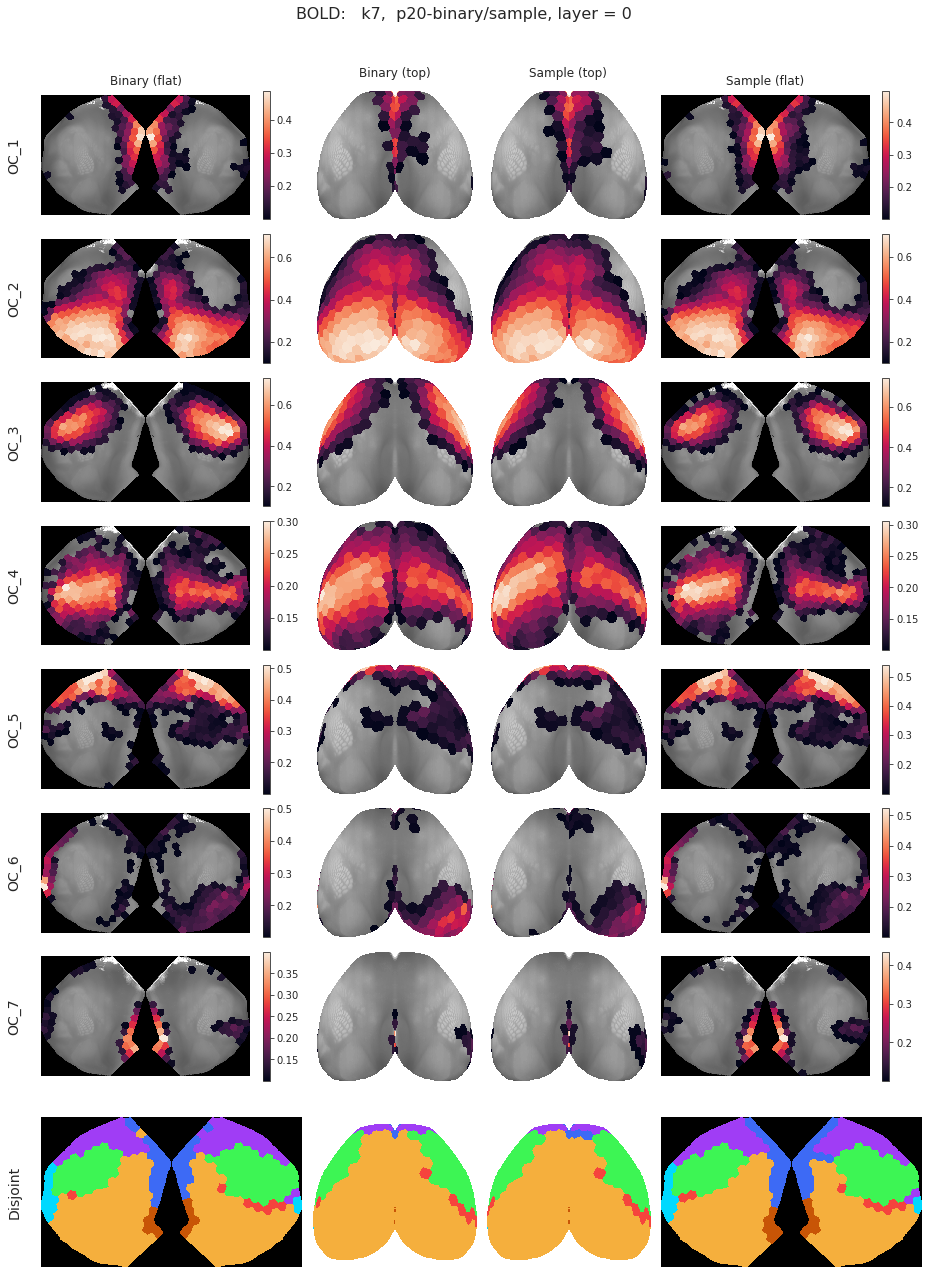

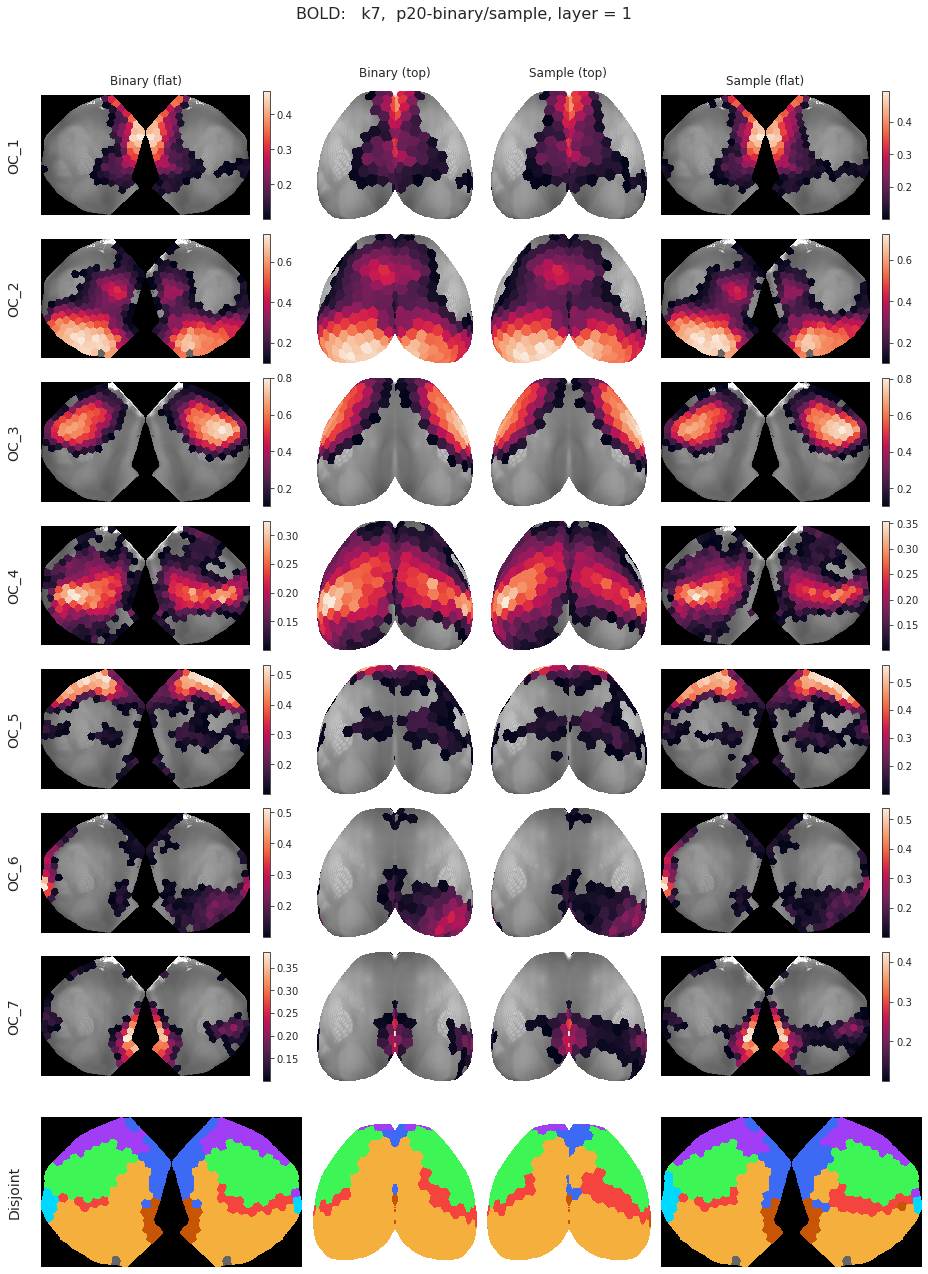

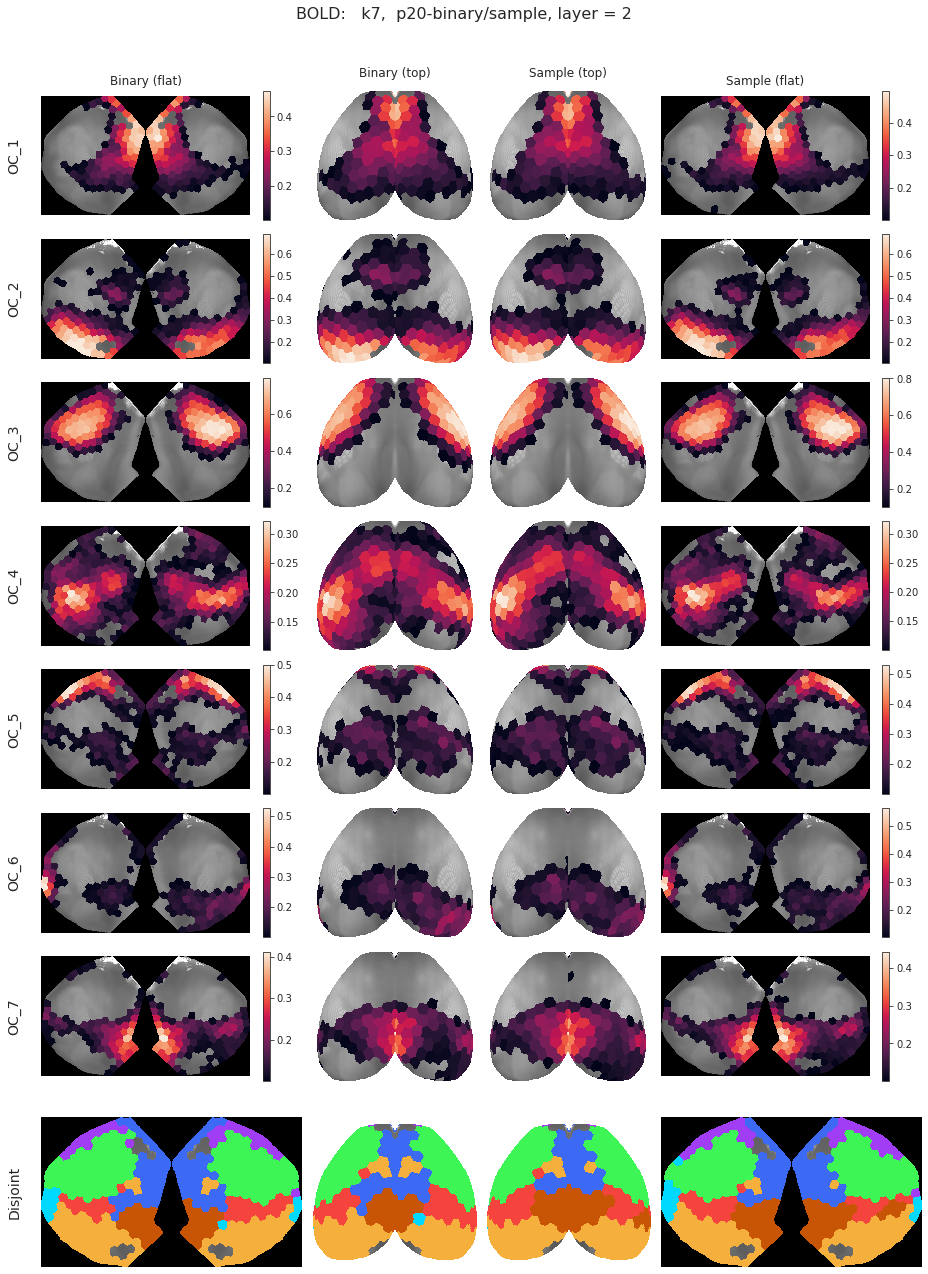

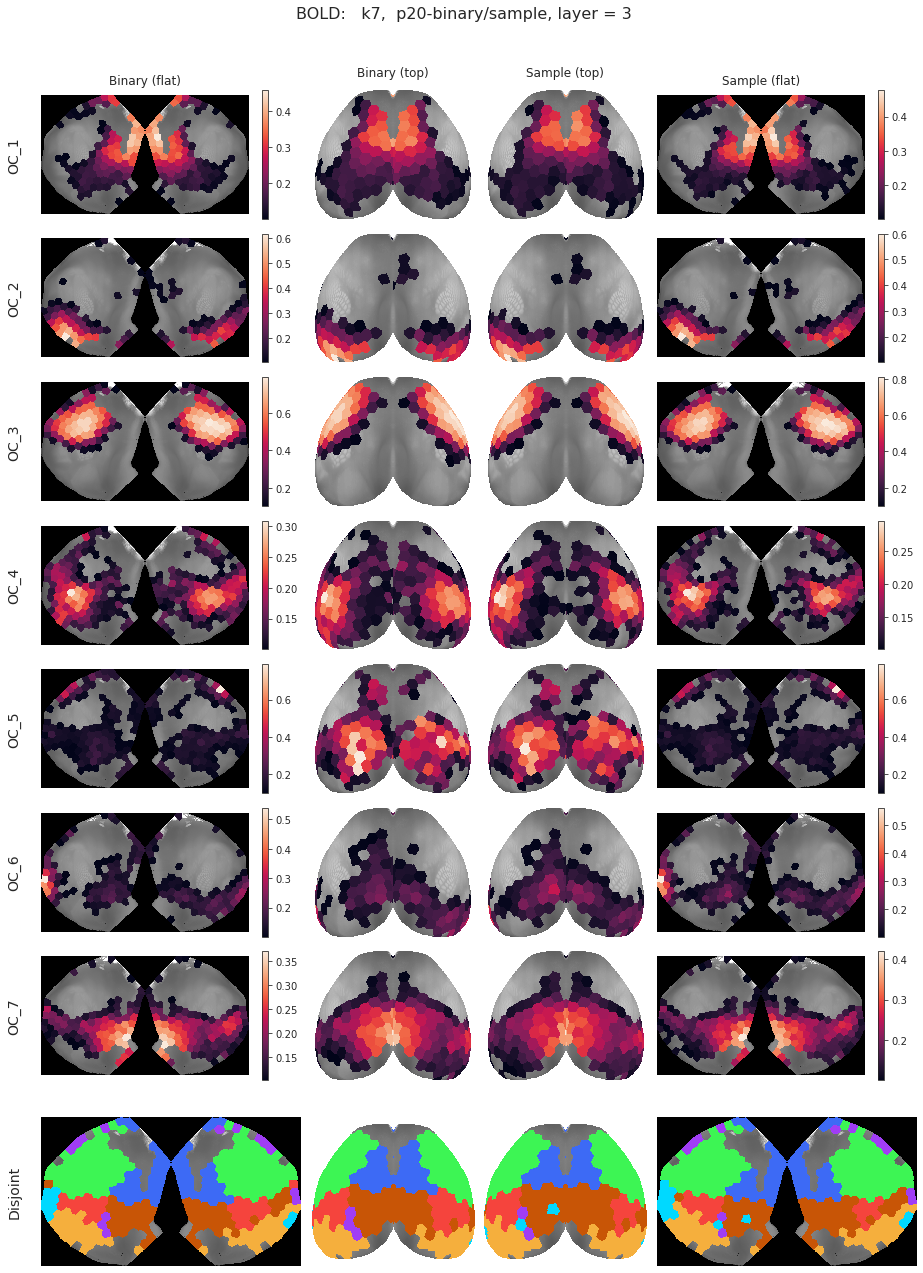

In [23]:
# Make fig, BOLD

for layer in range(mice.cfg.ll):
    fig, _ = gr_binary.show(
        proj_binary[layer], proj_sample[layer],
        labels=('Binary', 'Sample'),
        cmaps=('rocket',) * 2,
        display=False,
    )
    sup = f"BOLD:   k{props_binary.get('num_k')},  p20-binary/sample, layer = {layer}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)
    display(fig)

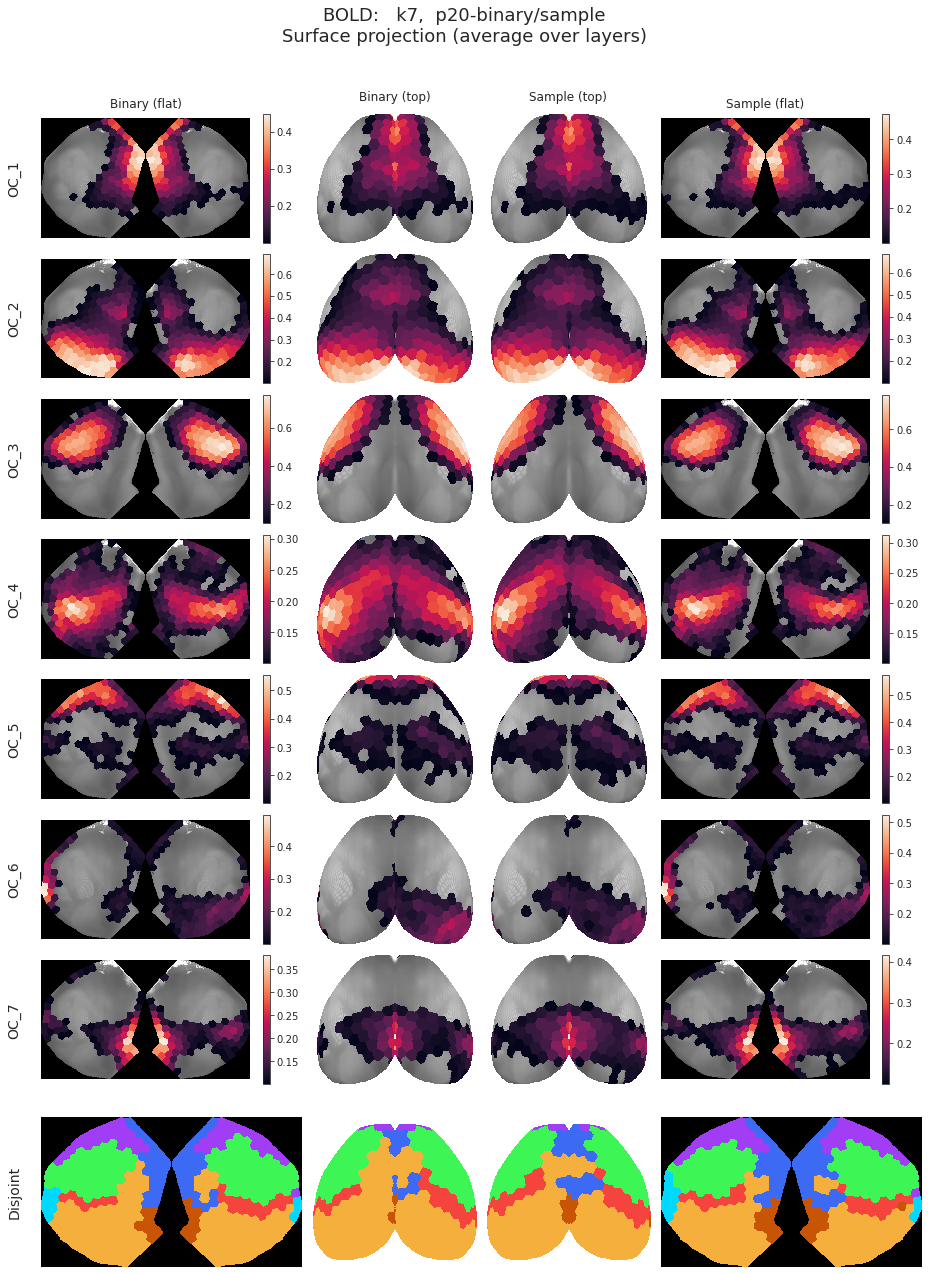

In [25]:
pi_surf_binary = gr_binary.get_surface_pi()
proj_surf_binary = gr_binary.project_vec(pi_surf_binary)

pi_surf_sample = gr_sample.get_surface_pi()
proj_surf_sample = gr_sample.project_vec(pi_surf_sample)

# Make fig, BOLD surface projection
fig, _ = gr_binary.show(
    proj_surf_binary, proj_surf_sample,
    labels=('Binary', 'Sample'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = f"BOLD:   k{props_binary.get('num_k')},  p20-binary/sample\n"
sup += 'Surface projection (average over layers)'
sup = fig.suptitle(sup, fontsize=18, y=1.02)

fig

In [26]:
sv = SVINET(mice, 7)

current expt: 'p30-sample'

In [27]:
sv.pi_symmetry_score(gr_binary.pi)

{1: 0.99, 2: 0.97, 3: 0.99, 4: 0.96, 5: 0.98, 6: 0.88, 7: 0.98, -1: 0.96}

In [28]:
sv.pi_symmetry_score(gr_sample.pi)

{1: 0.99, 2: 0.97, 3: 0.99, 4: 0.96, 5: 0.98, 6: 0.91, 7: 0.98, -1: 0.97}

## Vol

### 1) Binary

In [29]:
vol = np.zeros((gr_binary.num_k, *mice.parcel['cortex'].shape), dtype=float)

for node, lbl in gr_binary.n2l.items():
    ii = mice.parcel.encode(lbl)
    if len(lbl.split('-')) == 3:
        m = mice.parcel['cortex'] == ii
    else:
        m = mice.parcel['subcortex'] == ii
        if int(lbl.split('-')[0]) == 1:
            m *= mice.al.mask_l
        else:
            m *= mice.al.mask_r
    for i in range(gr_binary.num_k):
        vol[i][m] = gr_binary.pi[i][node]

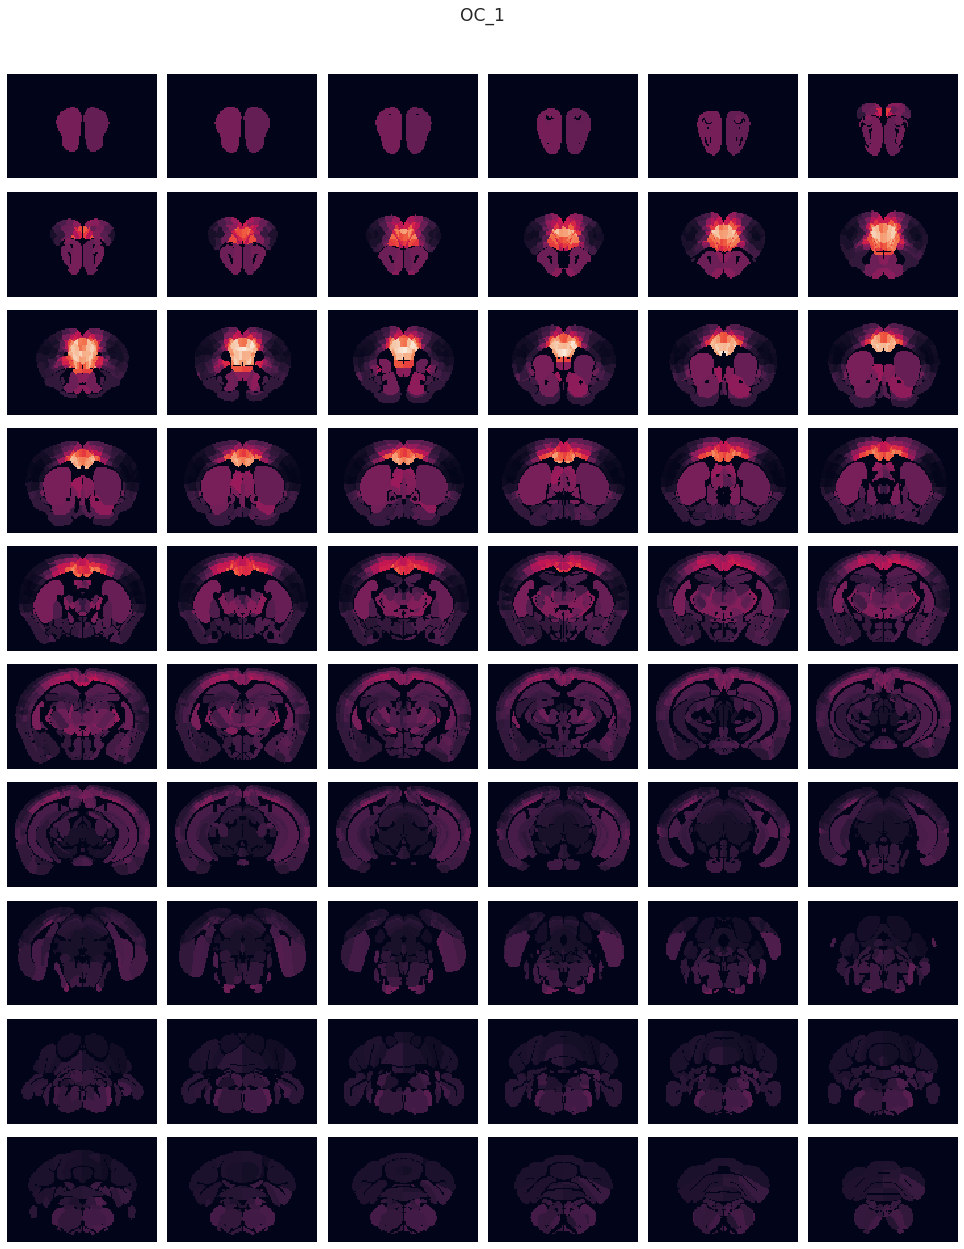

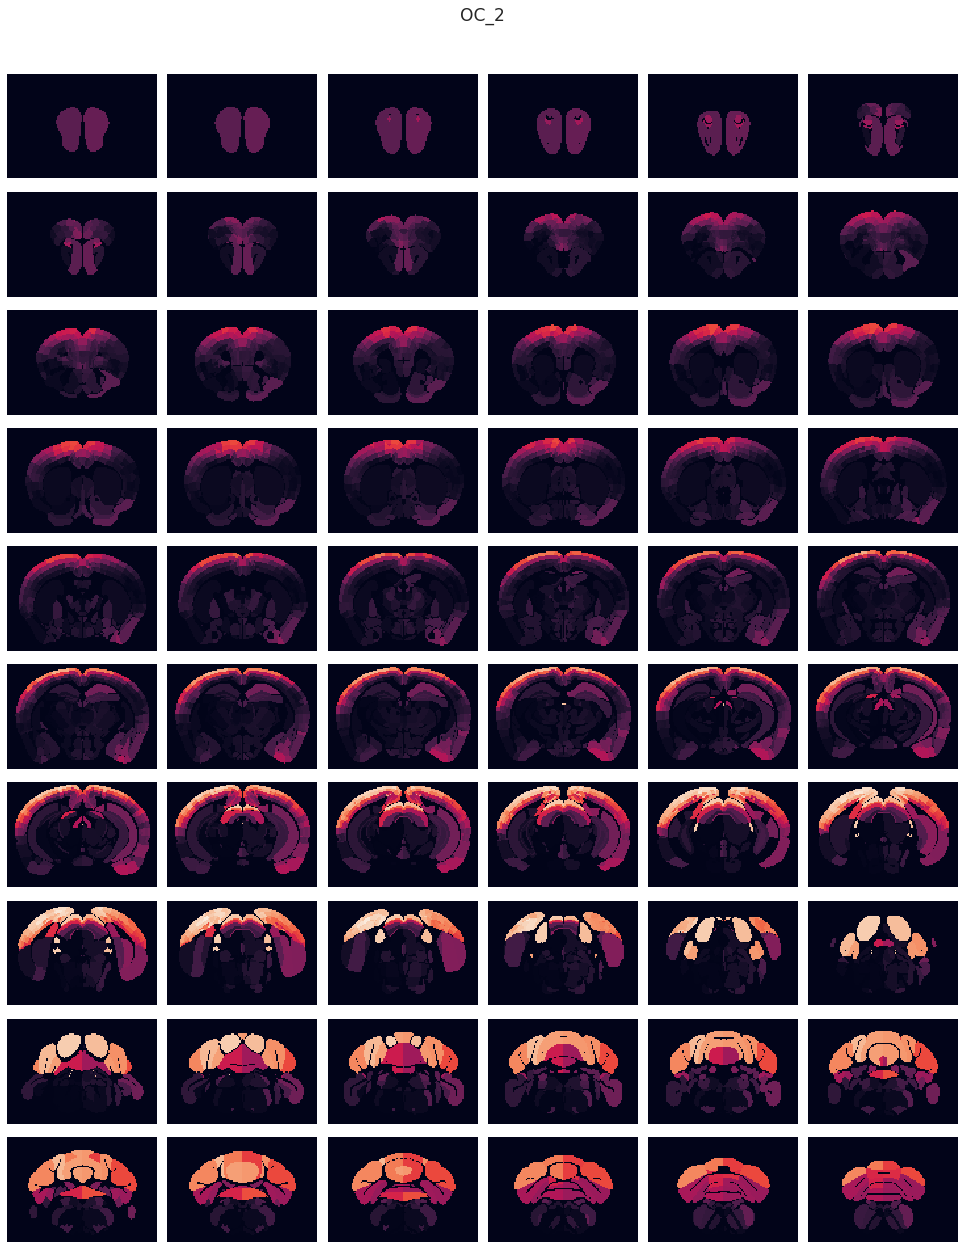

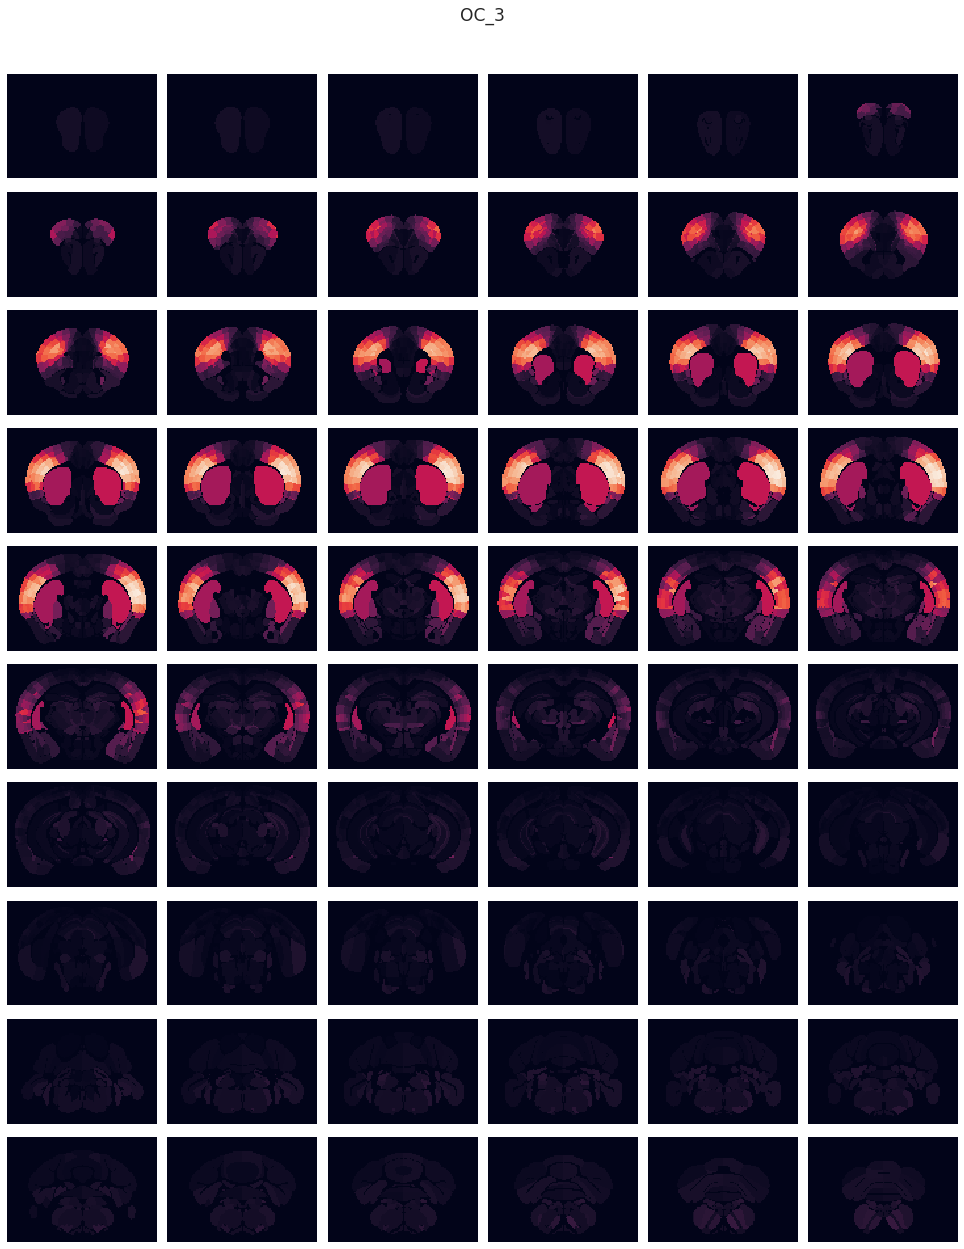

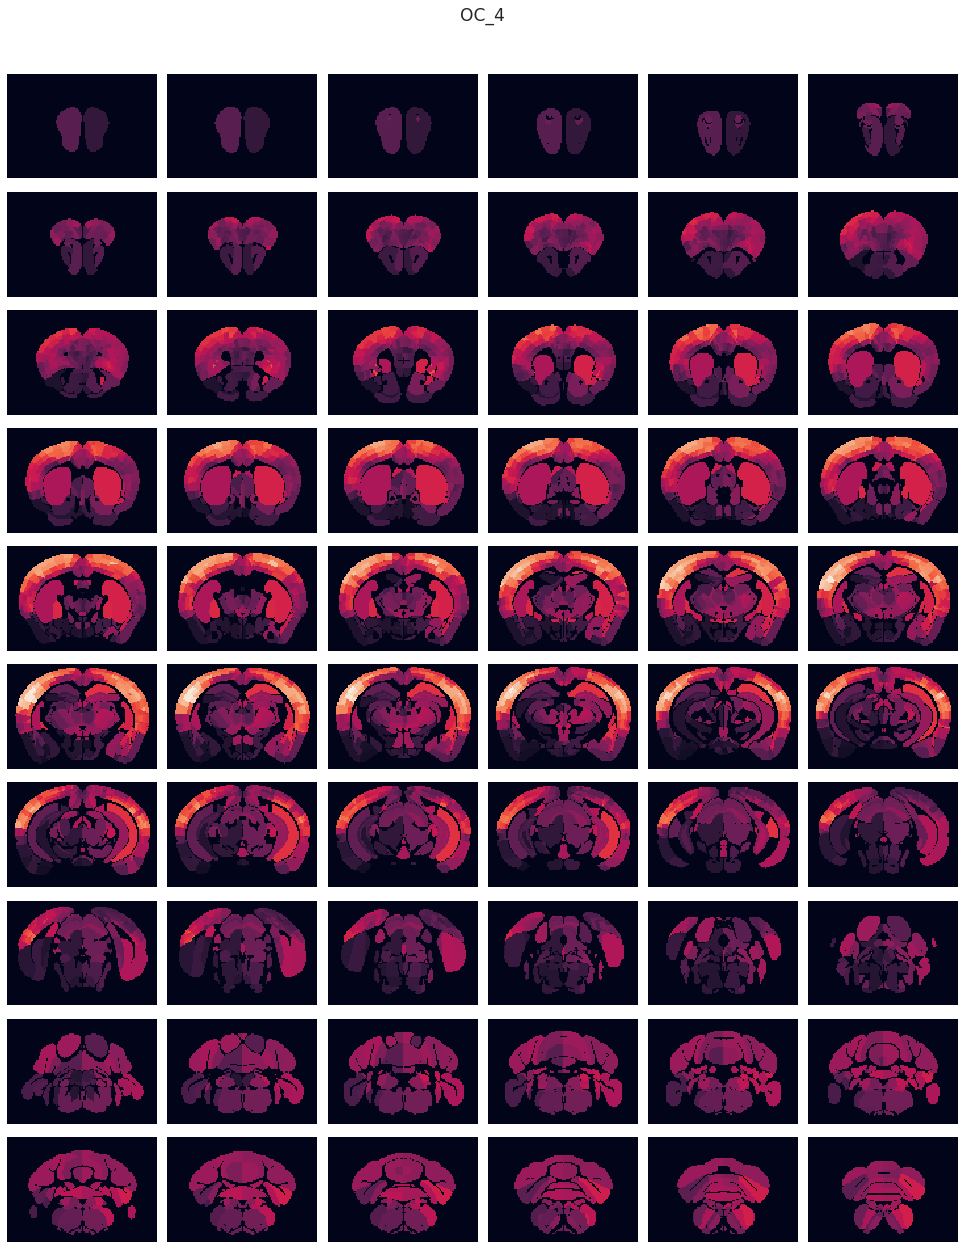

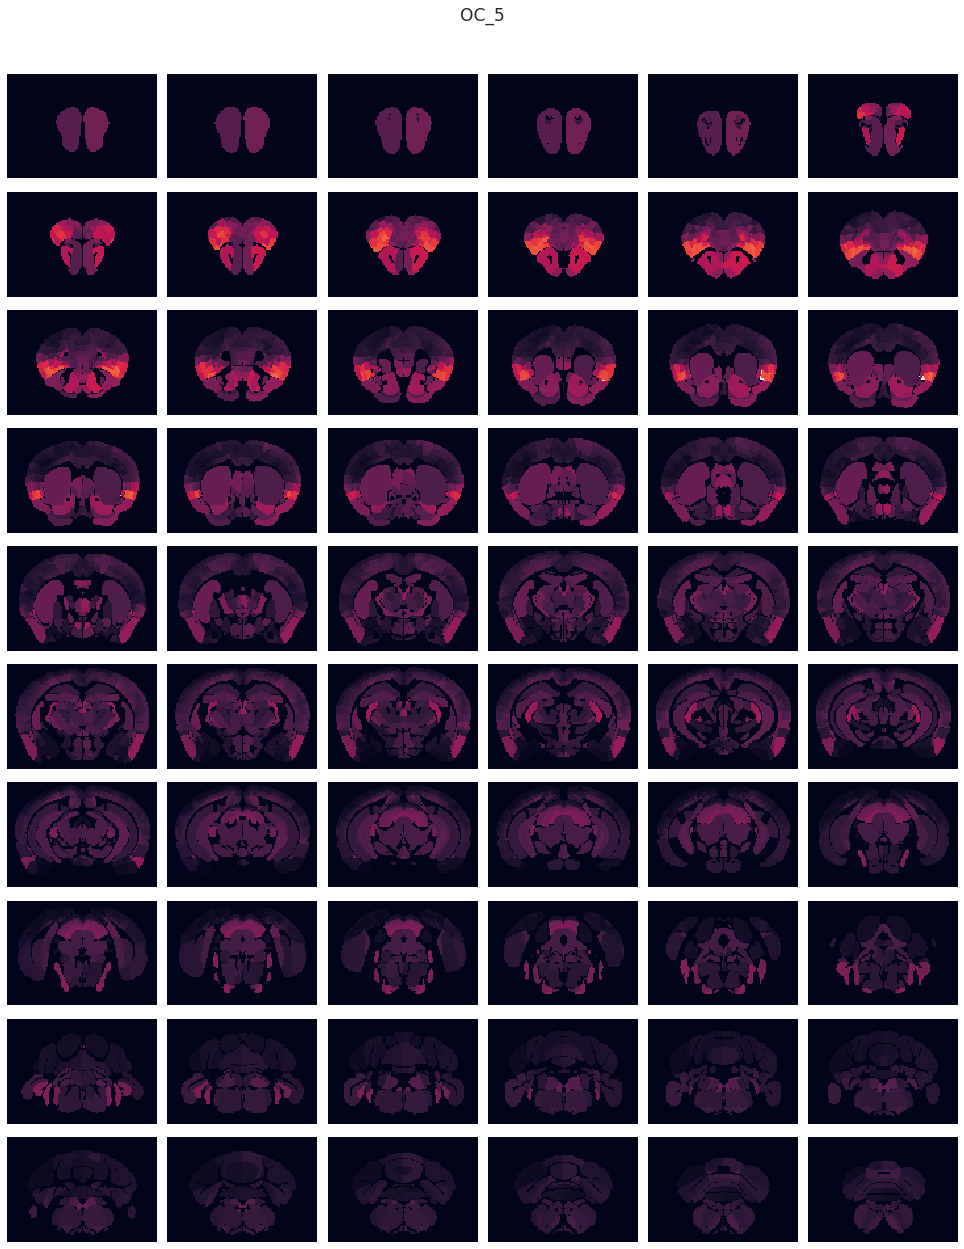

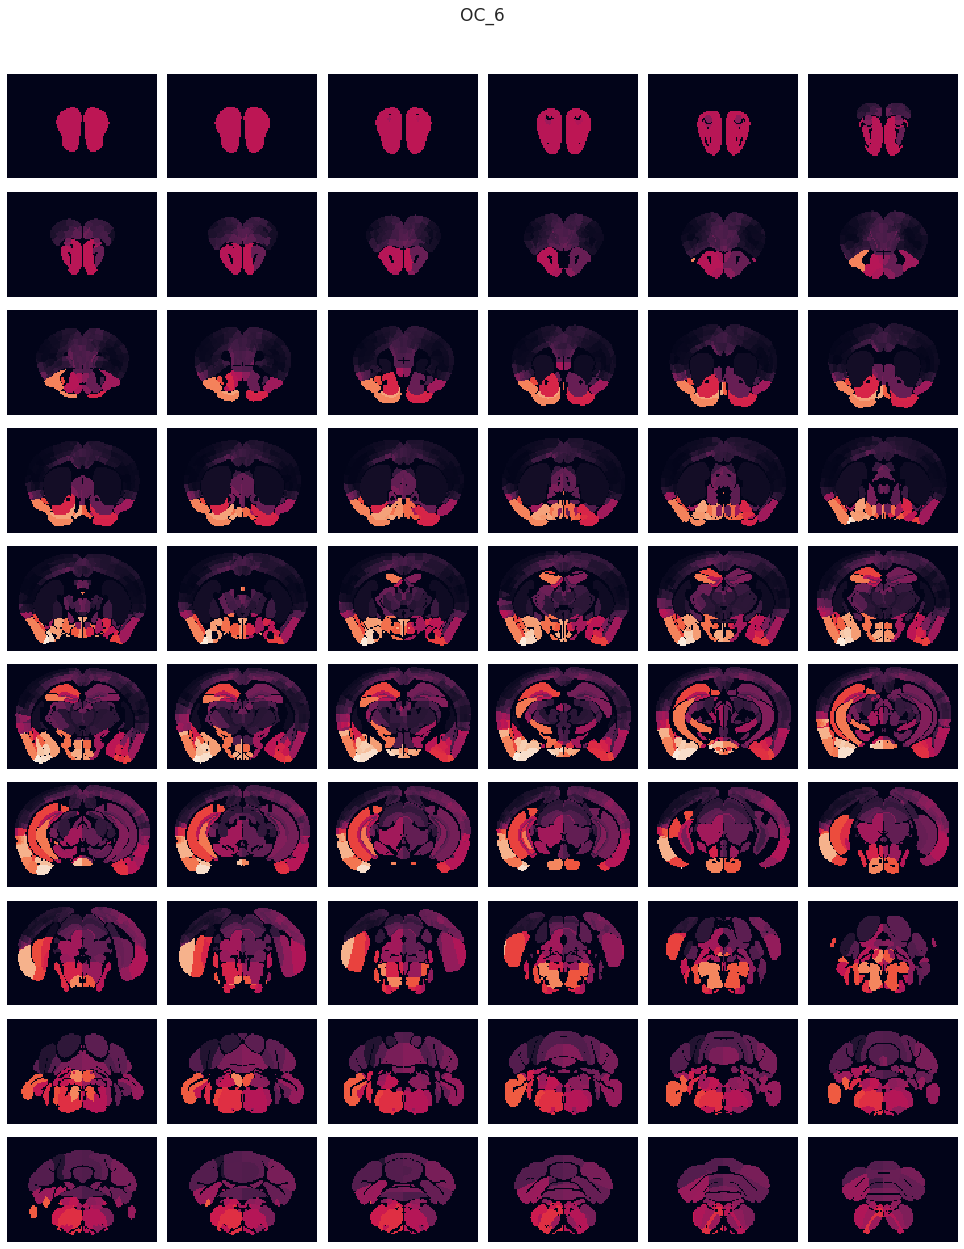

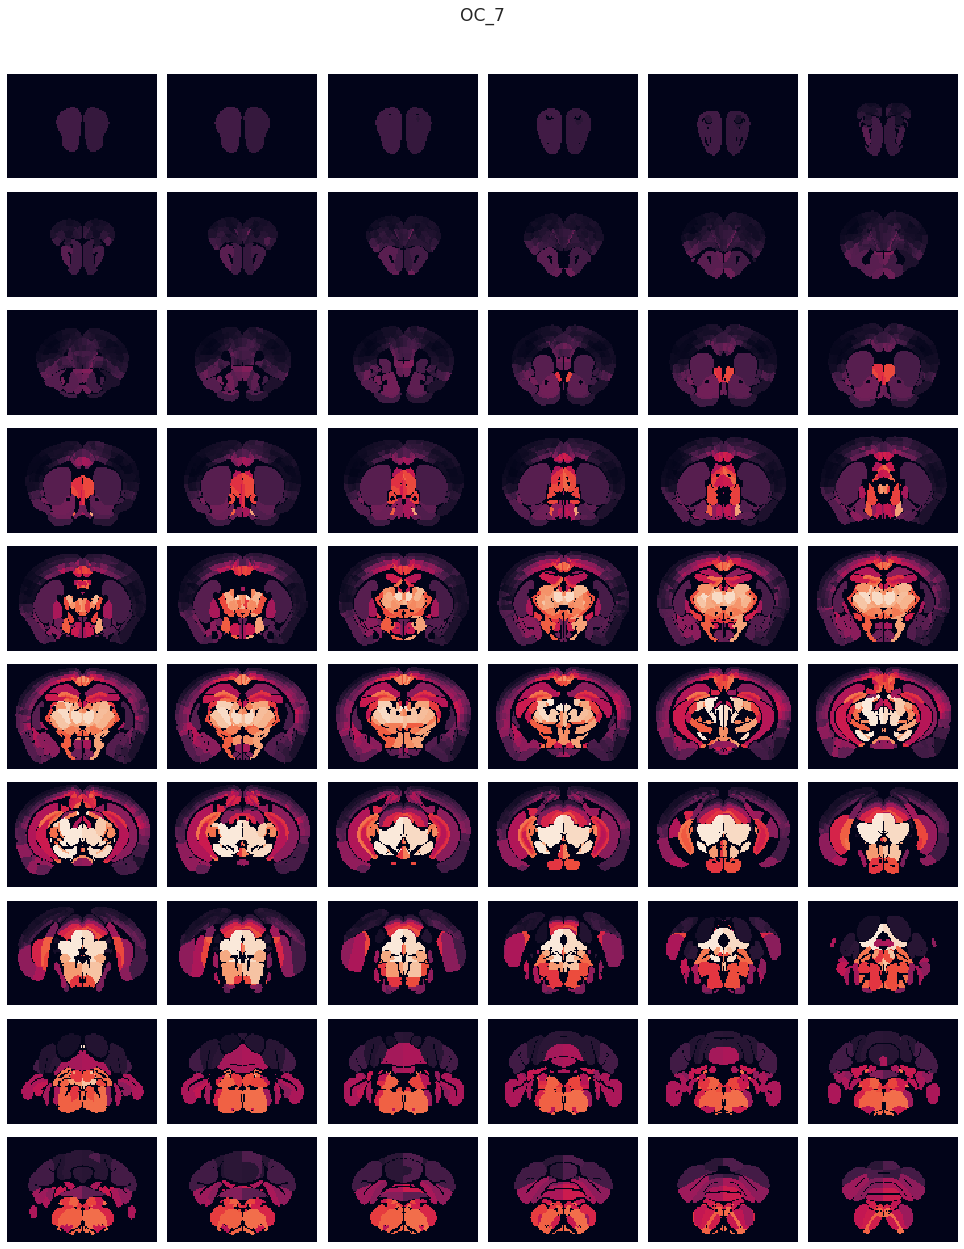

In [31]:
for oc_i in range(gr_binary.num_k):
    fig, axes = create_figure(10, 6, (13.5, 17))
    vmax = np.max(vol[oc_i])
    for i, jj in enumerate(range(10, 130, 2)):
        ax = axes.flat[i]
        ax.imshow(vol[oc_i][jj], vmin=0, vmax=vmax)
    fig.suptitle(f"OC_{oc_i+1}", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()

### 2) Sample

In [32]:
vol = np.zeros((gr_sample.num_k, *mice.parcel['cortex'].shape), dtype=float)

for node, lbl in gr_sample.n2l.items():
    ii = mice.parcel.encode(lbl)
    if len(lbl.split('-')) == 3:
        m = mice.parcel['cortex'] == ii
    else:
        m = mice.parcel['subcortex'] == ii
        if int(lbl.split('-')[0]) == 1:
            m *= mice.al.mask_l
        else:
            m *= mice.al.mask_r
    for i in range(gr_sample.num_k):
        vol[i][m] = gr_sample.pi[i][node]

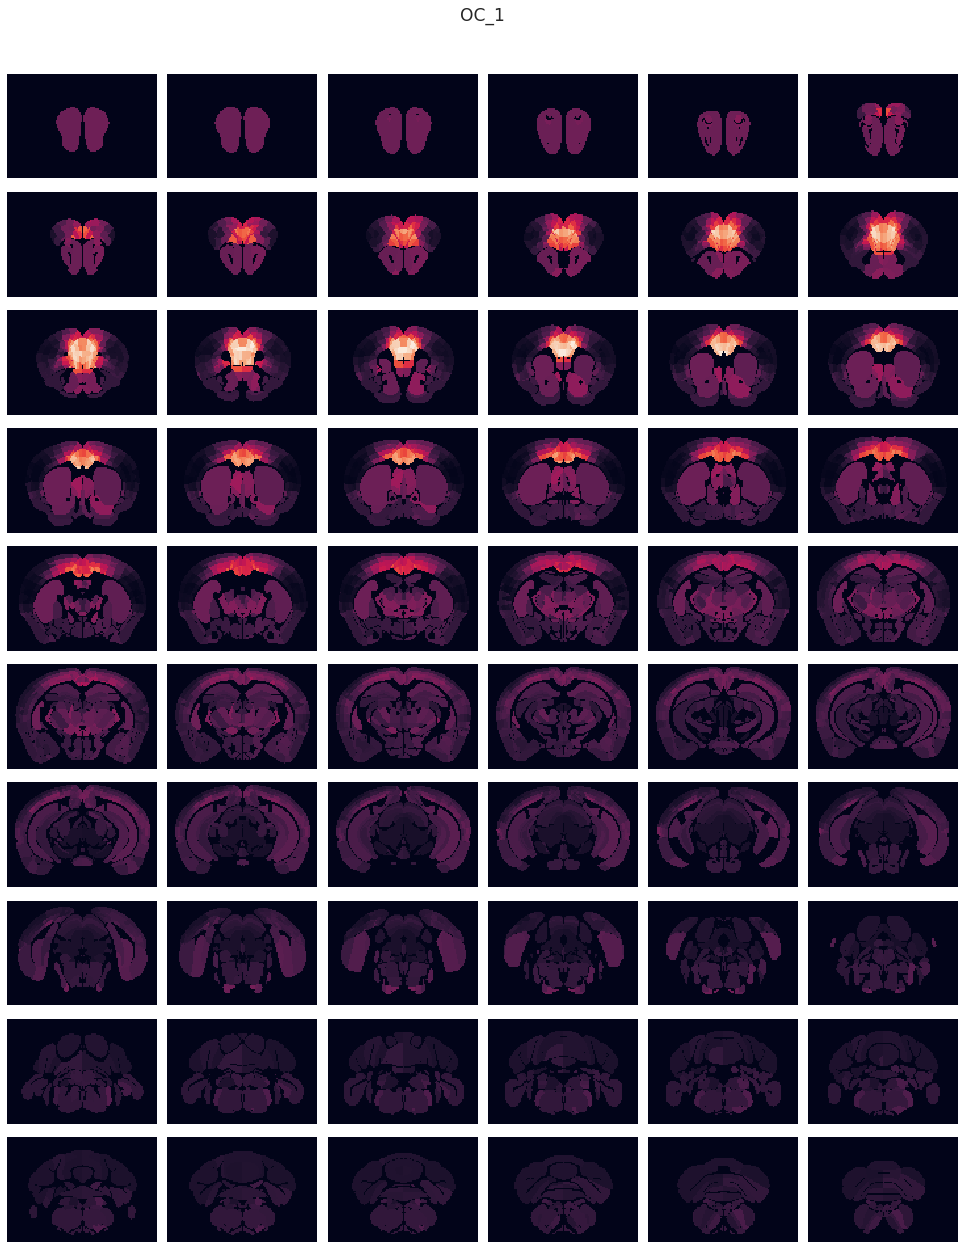

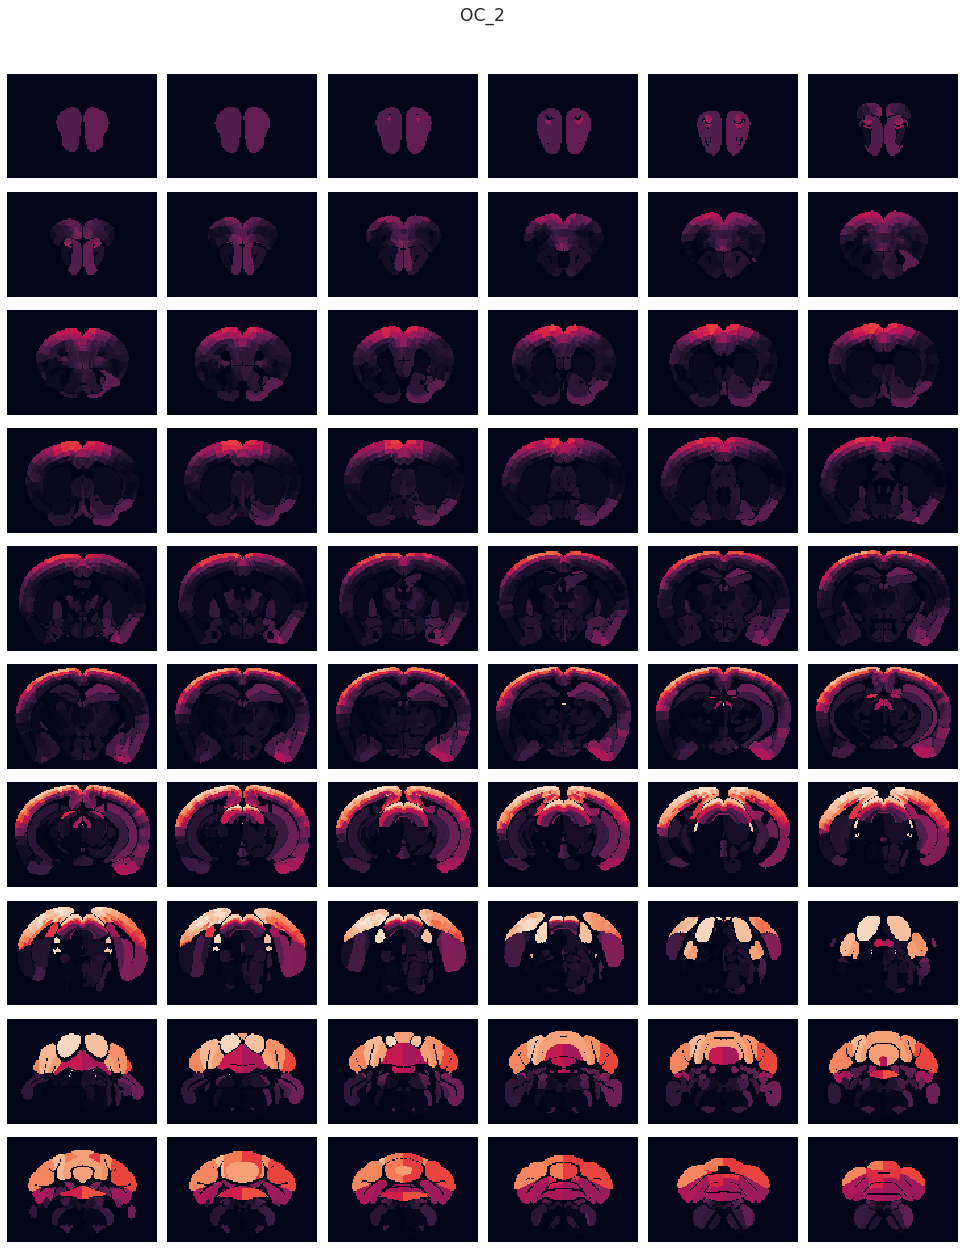

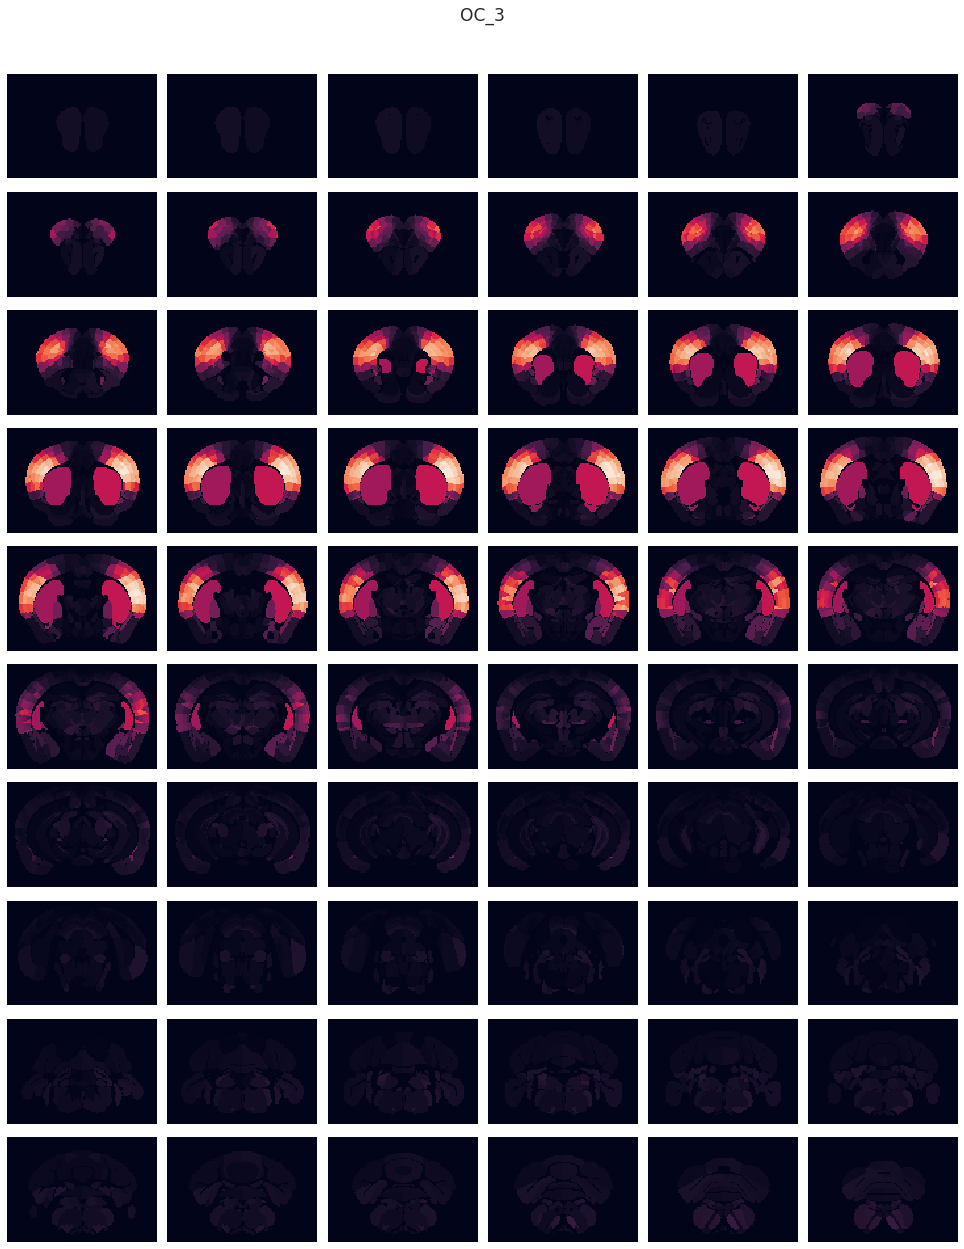

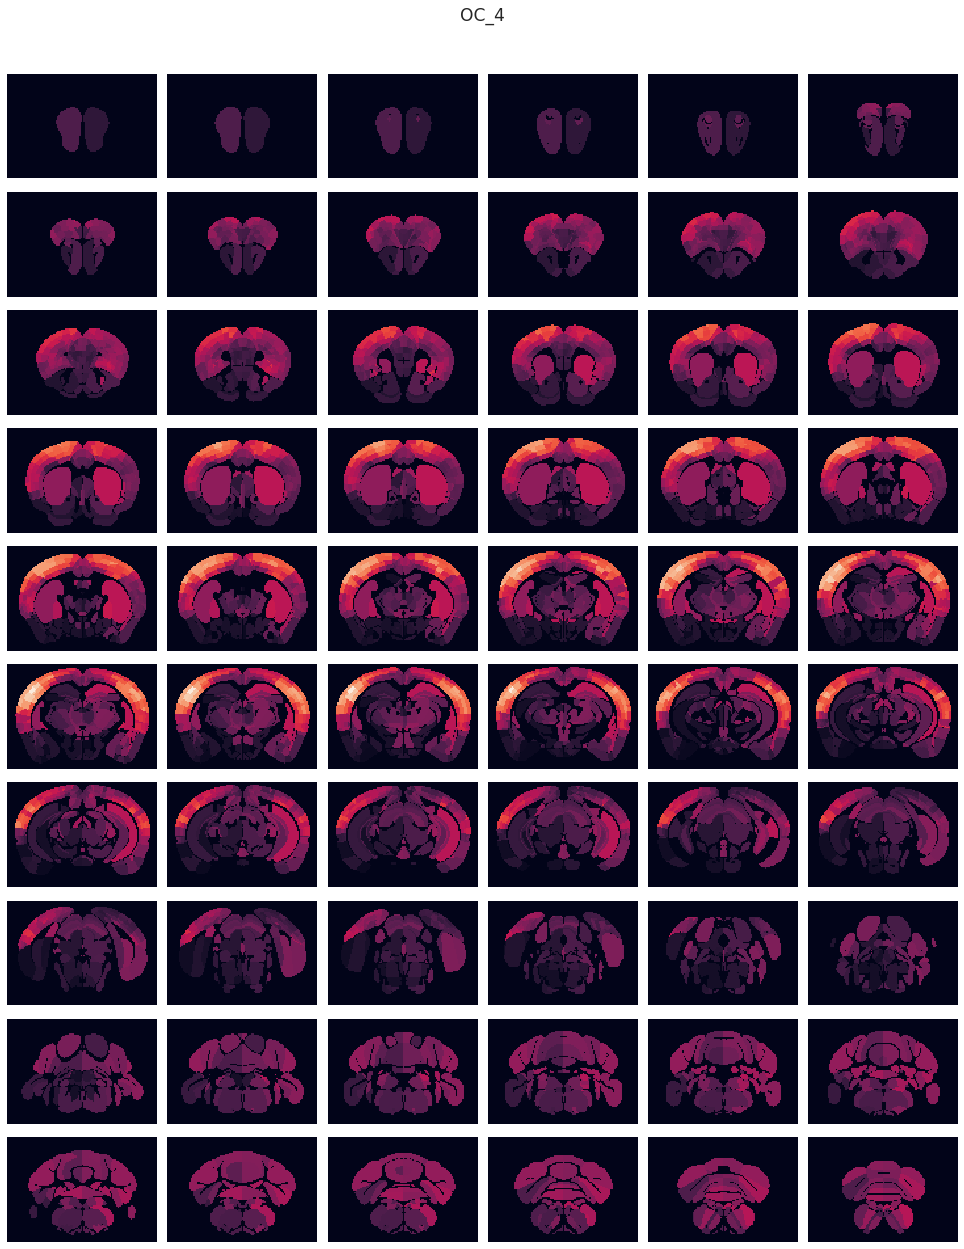

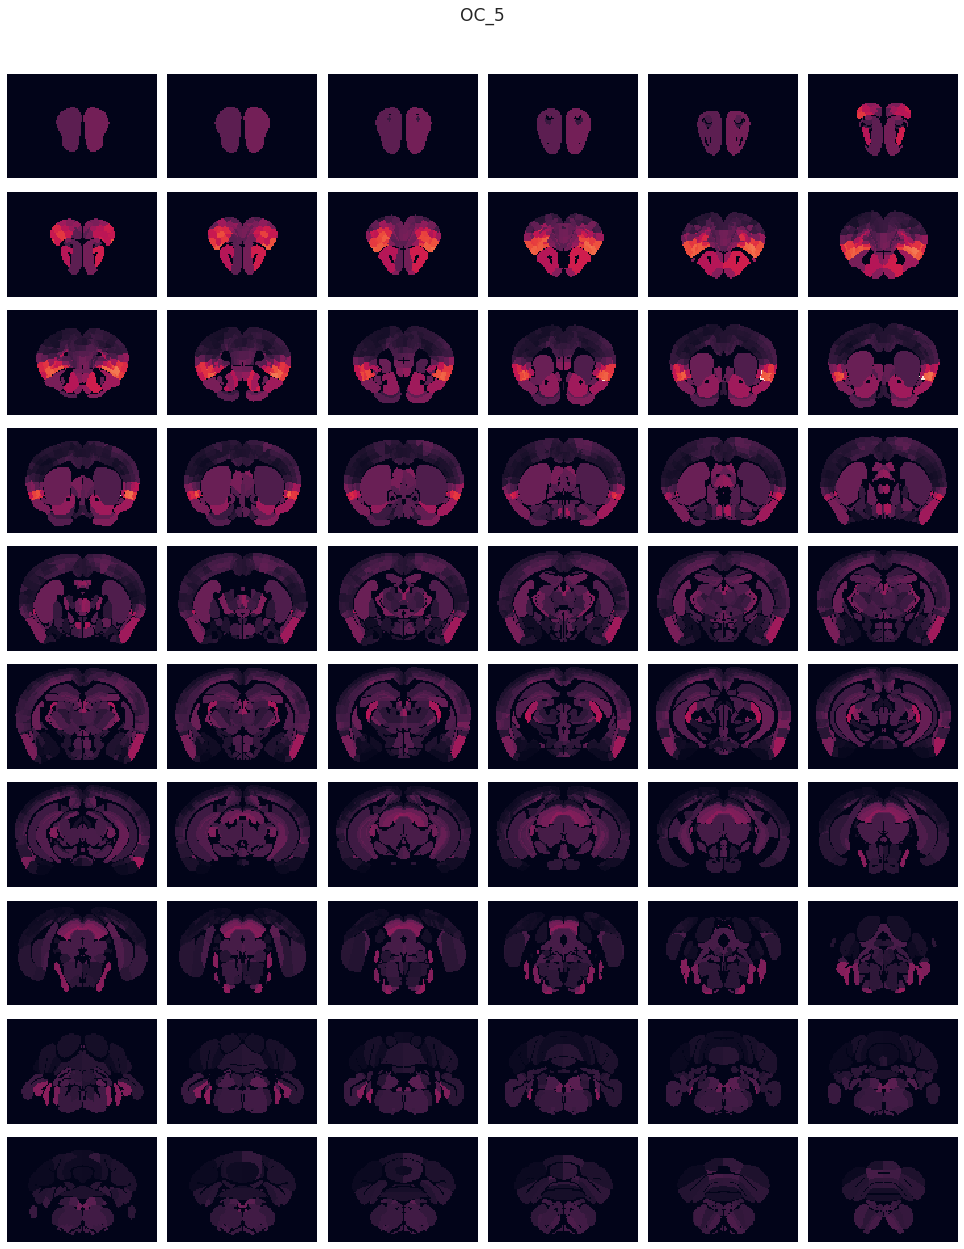

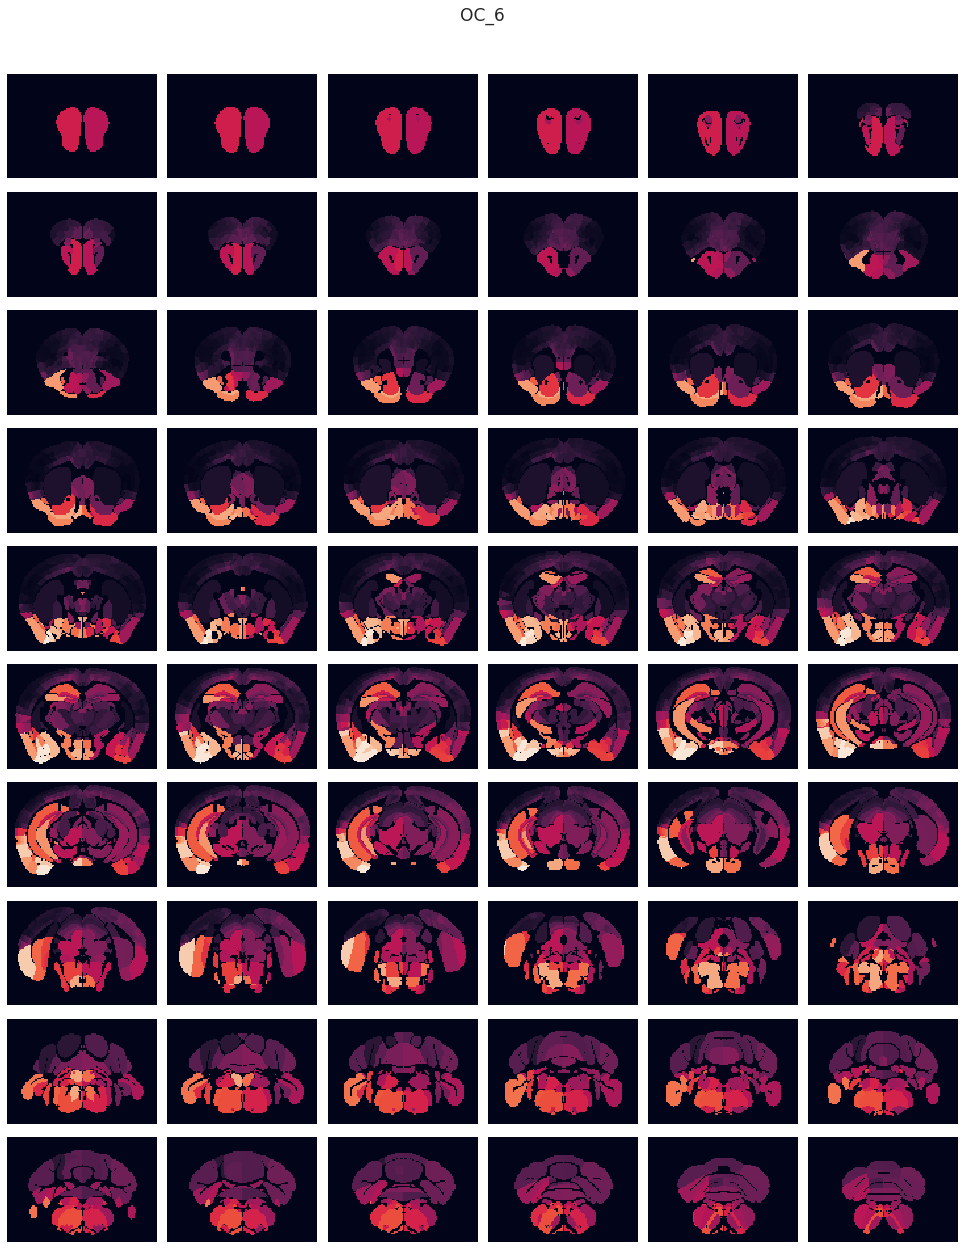

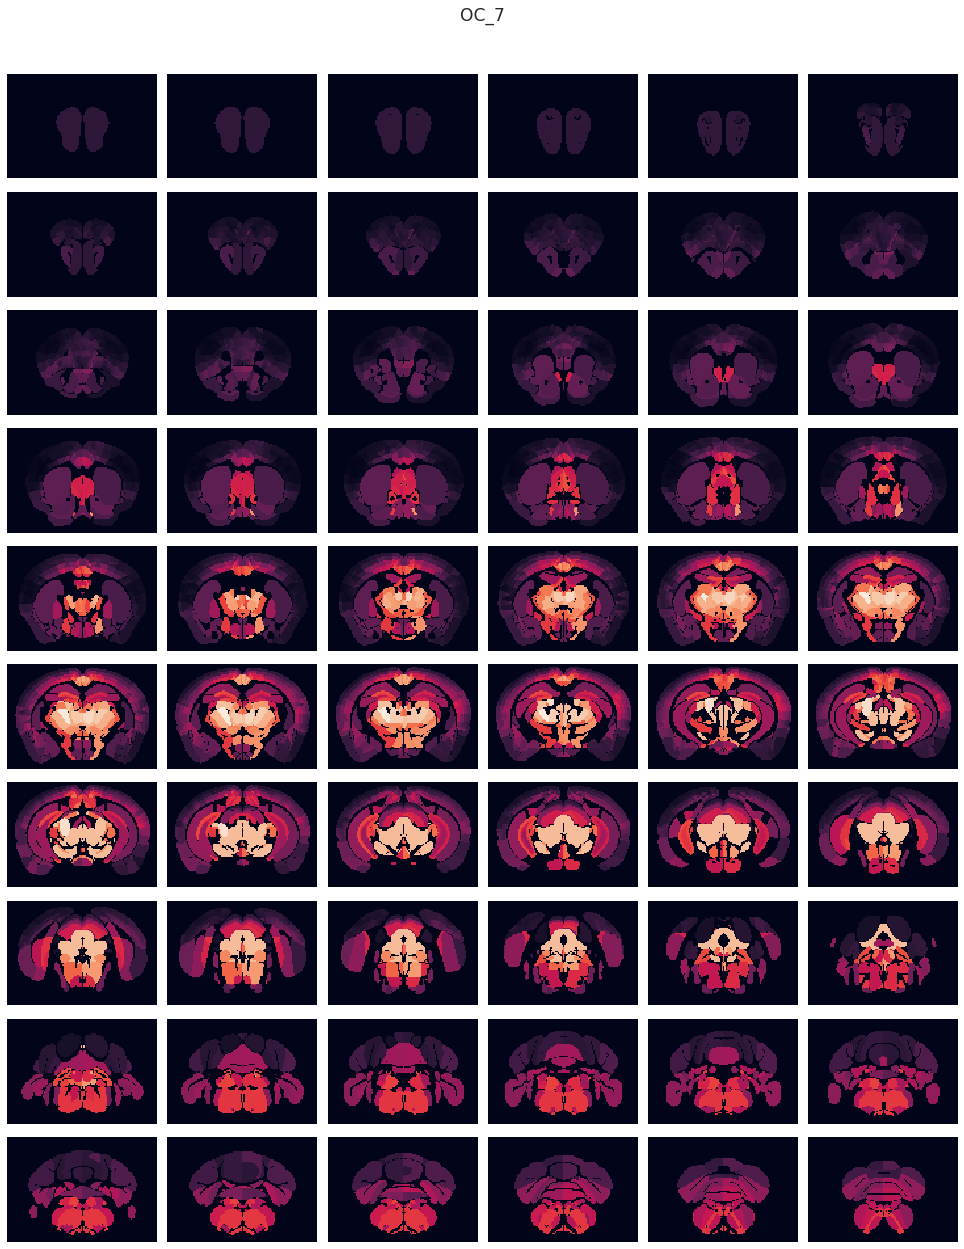

In [33]:
for oc_i in range(gr_sample.num_k):
    fig, axes = create_figure(10, 6, (13.5, 17))
    vmax = np.max(vol[oc_i])
    for i, jj in enumerate(range(10, 130, 2)):
        ax = axes.flat[i]
        ax.imshow(vol[oc_i][jj], vmin=0, vmax=vmax)
    fig.suptitle(f"OC_{oc_i+1}", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()